In [2]:
%pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=c91e1986574fc2244ab78e8bb41e17a0b4429915b9de9491b35989b335465a39
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Giả sử các thư viện khác và code phía trên đã được chạy
from sklearn.preprocessing import MinMaxScaler
import ta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
df_lsg = pd.read_csv('fpt_lsg.csv')
df_kn = pd.read_csv('fpt_kn.csv')

df_lsg['Ngày'] = pd.to_datetime(df_lsg['Ngày'], format='%Y-%m-%d')
df_kn['Ngày'] = pd.to_datetime(df_kn['Ngày'], format='%Y-%m-%d')

df_lsg = df_lsg.sort_values('Ngày').reset_index(drop=True)
df_kn = df_kn.sort_values('Ngày').reset_index(drop=True)

df_lsg = df_lsg.rename(columns={
    'Ngày': 'Date', 'Giá đóng cửa': 'Close', 'Giá mở cửa': 'Open',
    'Giá cao nhất': 'High', 'Giá thấp nhất': 'Low', 'KL gd khớp lệnh': 'Volume'
})
df_lsg = df_lsg[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

df_kn = df_kn.rename(columns={
    'Ngày': 'Date', 'KL giao dịch ròng': 'NetForeignVolume', 'GT giao dịch ròng': 'NetForeignValue'
})
df_kn = df_kn[['Date', 'NetForeignVolume', 'NetForeignValue']]

for col in ['NetForeignVolume', 'NetForeignValue']:
    if df_kn[col].dtype == 'object':
        df_kn[col] = df_kn[col].str.replace(',', '', regex=False).astype(float)

df_merged = pd.merge(df_lsg, df_kn, on='Date', how='inner')

# --- Helper Function để tính toán chỉ báo kỹ thuật (sử dụng thư viện ta) ---
def add_technical_indicators(df):
    # SMA
    df['SMA_20'] = ta.trend.SMAIndicator(close=df['Close'], window=20, fillna=True).sma_indicator()
    # EMA
    df['EMA_20'] = ta.trend.EMAIndicator(close=df['Close'], window=20, fillna=True).ema_indicator()
    # MACD
    macd_indicator = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9, fillna=True)
    df['MACD'] = macd_indicator.macd()
    df['MACD_signal'] = macd_indicator.macd_signal()
    df['MACD_hist'] = macd_indicator.macd_diff() # MACD Histogram
    # RSI
    df['RSI_14'] = ta.momentum.RSIIndicator(close=df['Close'], window=14, fillna=True).rsi()
    return df

df_features = add_technical_indicators(df_merged.copy())
df_all = df_features.dropna().reset_index(drop=True)

In [39]:
df_all

,Date,Open,High,Low,Close,Volume,NetForeignVolume,NetForeignValue,SMA_20,EMA_20,MACD,MACD_signal,MACD_hist,RSI_14
0,2006-12-13,400.0,400.0,400.0,400.0,83530,1240,0.00,400.000000,400.000000,0.000000,0.000000,0.000000,100.000000
1,2006-12-14,420.0,420.0,420.0,420.0,280710,178460,0.07,410.000000,401.904762,1.595442,0.319088,1.276353,100.000000
2,2006-12-15,441.0,441.0,441.0,441.0,265300,1650,0.00,420.333333,405.628118,4.502463,1.155763,3.346700,100.000000
3,2006-12-18,463.0,463.0,463.0,463.0,215790,123310,0.06,431.000000,411.092107,8.483720,2.621355,5.862366,100.000000
4,2006-12-19,486.0,486.0,486.0,486.0,137520,46450,0.02,442.000000,418.226192,13.341016,4.765287,8.575729,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4531,2025-04-29,109.6,110.5,109.1,109.4,2945500,-401800,-44.02,112.485000,114.098915,-4.387536,-5.034871,0.647335,37.494194
4532,2025-05-05,109.5,109.7,106.9,108.6,7167600,2391269,-230.69,111.890000,113.575208,-4.312141,-4.890325,0.578184,36.459702
4533,2025-05-06,108.6,111.0,108.6,109.7,5686200,318700,34.96,111.275000,113.206141,-4.116181,-4.735496,0.619316,38.953775
4534,2025-05-07,109.6,111.2,108.9,109.7,3926800,-212400,-23.14,111.085000,112.872223,-3.915742,-4.571545,0.655803,38.953775


In [58]:
features = ['Open', 'High', 'Low', 'Close', 'Volume',
                   'NetForeignVolume', 'NetForeignValue',
                   'SMA_20', 'EMA_20', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI_14']

# Drop rows where moving averages or indicators are missing
print("Rows before dropping NaNs:", len(df_all))
df_all = df_all.dropna().reset_index(drop=True)
print("Rows after dropping NaNs:", len(df_all))

scaler = MinMaxScaler()
df_all[features] = scaler.fit_transform(df_all[features])

print("Features normalized. Ready for dataset creation.")


Rows before dropping NaNs: 4536
Rows after dropping NaNs: 4536
Features normalized. Ready for dataset creation.


In [44]:
len(df_all)

4536

In [51]:
print(df_all[features].isnull().sum().sum()) # Kiểm tra tổng số NaN
print(np.isinf(df_all[features].values).sum()) # Kiểm tra tổng số Inf
print(df_all[features].describe()) # Kiểm tra dải giá trị

0
0
              Open         High          Low        Close        Volume  \
count  4536.000000  4536.000000  4536.000000  4536.000000  4.536000e+03   
mean     79.967912    80.784182    79.182044    79.960681  1.178852e+06   
std      71.041886    71.649483    70.415350    71.044999  1.566711e+06   
min      32.200000    32.600000    32.100000    32.300000  0.000000e+00   
25%      47.300000    47.700000    47.000000    47.250000  2.528325e+05   
50%      56.300000    57.000000    55.500000    56.200000  6.556900e+05   
75%      85.000000    85.800000    84.000000    85.000000  1.547782e+06   
max     635.000000   645.000000   635.000000   645.000000  2.157450e+07   

       NetForeignVolume  NetForeignValue       SMA_20       EMA_20  \
count      4.536000e+03      4536.000000  4536.000000  4536.000000   
mean      -5.798107e+03        -1.721316    80.657211    80.561744   
std        3.567371e+05        44.661774    72.480587    71.775464   
min       -8.414700e+06     -1061.700000

In [52]:
sample_xb, sample_yb = next(iter(train_loader))
print("Sample X contains NaN:", torch.isnan(sample_xb).any())
print("Sample X contains Inf:", torch.isinf(sample_xb).any())
print("Sample y contains NaN:", torch.isnan(sample_yb).any())
print("Sample y contains Inf:", torch.isinf(sample_yb).any())

Sample X contains NaN: tensor(False)
Sample X contains Inf: tensor(False)
Sample y contains NaN: tensor(False)
Sample y contains Inf: tensor(False)


In [59]:
sequence_length = 60  # 60 days
target_col = 'Close'

class StockDataset(Dataset):
    def __init__(self, df, features, seq_len):
        self.X = []
        self.y = []


        for i in range(len(df) - seq_len):
            seq_x = df[features].iloc[i:i+seq_len].values
            seq_y = df[target_col].iloc[i+seq_len]
            self.X.append(seq_x)
            self.y.append(seq_y)
        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Train / Val / Test split
cut1 = int(len(df_all) * 0.7)
cut2 = int(len(df_all) * 0.85)

df_train = df_all.iloc[:cut1]
df_val = df_all.iloc[cut1:cut2]
df_test = df_all.iloc[cut2:]

train_ds = StockDataset(df_train, features, sequence_length)
val_ds = StockDataset(df_val, features, sequence_length)
test_ds = StockDataset(df_test, features, sequence_length)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

print("Datasets and DataLoaders ready.")

Datasets and DataLoaders ready.


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [61]:
class LSTMInformerHybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden, transformer_heads):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.lstm_fc = nn.Linear(lstm_hidden, 32)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=transformer_heads,
            dim_feedforward=64,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.trans_fc = nn.Linear(input_dim, 32)

        self.final_fc = nn.Linear(64, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # last timestep
        lstm_out = self.lstm_fc(lstm_out)

        trans_out = self.transformer(x)
        trans_out = trans_out.mean(dim=1)
        trans_out = self.trans_fc(trans_out)

        combined = torch.cat([lstm_out, trans_out], dim=1)
        out = self.final_fc(combined)
        return out.squeeze()

input_dim = len(features)
model = LSTMInformerHybrid(input_dim=input_dim, lstm_hidden=64, transformer_heads=1).to(device)
print("Model ready.")

Model ready.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [62]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

best_val_loss = float('inf')
train_losses = []
val_losses = []

epochs = 50
torch.autograd.set_detect_anomaly(True)
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("  ↳ Saved best model.")

Epoch 1 | Train Loss: 0.018322 | Val Loss: 0.001312
  ↳ Saved best model.
Epoch 2 | Train Loss: 0.008187 | Val Loss: 0.000581
  ↳ Saved best model.
Epoch 3 | Train Loss: 0.002116 | Val Loss: 0.000203
  ↳ Saved best model.
Epoch 4 | Train Loss: 0.000397 | Val Loss: 0.000157
  ↳ Saved best model.
Epoch 5 | Train Loss: 0.000302 | Val Loss: 0.000203
Epoch 6 | Train Loss: 0.000267 | Val Loss: 0.000174
Epoch 7 | Train Loss: 0.000244 | Val Loss: 0.000083
  ↳ Saved best model.
Epoch 8 | Train Loss: 0.000221 | Val Loss: 0.000093
Epoch 9 | Train Loss: 0.000209 | Val Loss: 0.000136
Epoch 10 | Train Loss: 0.000195 | Val Loss: 0.000148
Epoch 11 | Train Loss: 0.000183 | Val Loss: 0.000180
Epoch 12 | Train Loss: 0.000176 | Val Loss: 0.000129
Epoch 13 | Train Loss: 0.000179 | Val Loss: 0.000104
Epoch 14 | Train Loss: 0.000168 | Val Loss: 0.000088
Epoch 15 | Train Loss: 0.000159 | Val Loss: 0.000072
  ↳ Saved best model.
Epoch 16 | Train Loss: 0.000159 | Val Loss: 0.000091
Epoch 17 | Train Loss: 0.0001

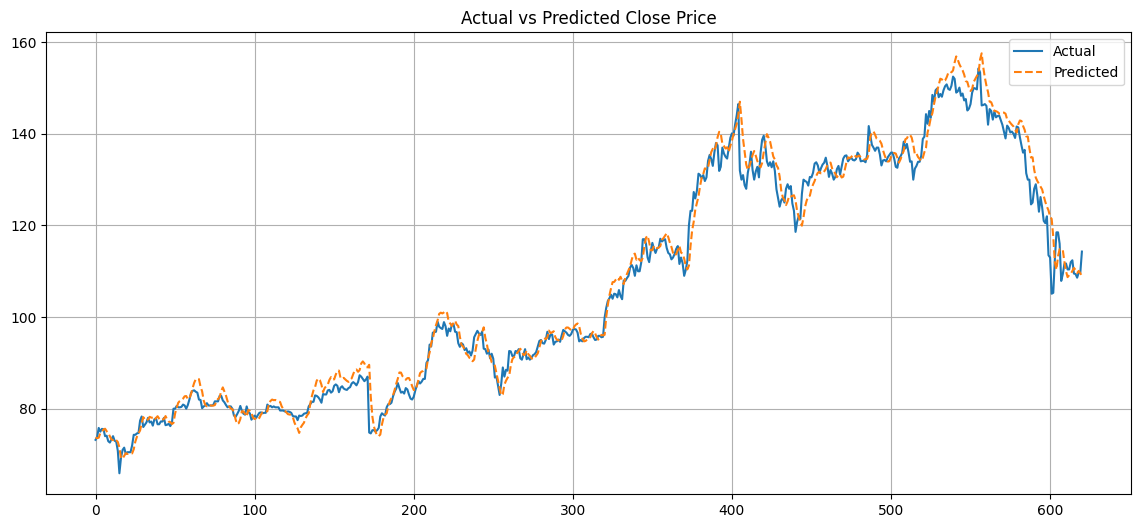

MAE: 2.21 | RMSE: 3.14 | R²: 0.9840


In [63]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

# Reverse scaling
close_min = scaler.data_min_[features.index("Close")]
close_max = scaler.data_max_[features.index("Close")]

y_true_rescaled = np.array(y_true)*(close_max - close_min) + close_min
y_pred_rescaled = np.array(y_pred)*(close_max - close_min) + close_min

plt.figure(figsize=(14, 6))
plt.plot(y_true_rescaled, label="Actual")
plt.plot(y_pred_rescaled, label="Predicted", linestyle='--')
plt.title("Actual vs Predicted Close Price")
plt.legend()
plt.grid()
plt.show()
mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_true_rescaled, y_pred_rescaled))
r2 = r2_score(y_true_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}")